In [1]:

%cd ..

import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import sys,os

import functions

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import seaborn as sns
from tqdm import tqdm

import multiprocessing
from joblib import Parallel, delayed
import pickle

d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
df = pd.read_csv(r'D:\projects\ripple_heterogeneity\df2.csv')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (108,120,127) have mixed types.Specify dtype option on import or set low_memory=False.


In [188]:
import warnings
warnings.filterwarnings("ignore")
def run_all(basepath,basename,save_path):
    '''
    run_all: loads data and runs analysis 
    '''

    cell_metrics,data = functions.load_cell_metrics(
                os.path.join(basepath,basename+'.cell_metrics.cellinfo.mat')
                )
    ripples = functions.load_ripples_events(
                os.path.join(basepath,basename+'.ripples.events.mat')
                )
                
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), fs=fs_dat)

    avg_fr_not_rip = st[~ripple_epochs].n_spikes / st[~ripple_epochs].support.duration
    avg_fr_in_rip = st[ripple_epochs].n_spikes / st[ripple_epochs].support.duration

    # ripple_gain = avg_fr_rip / avg_fr_not_rip
    ripple_gain = (avg_fr_in_rip - avg_fr_not_rip)  / (avg_fr_in_rip + avg_fr_not_rip)

    cell_metrics['ripple_gain'] = ripple_gain
    cell_metrics['avg_fr_in_rip'] = avg_fr_in_rip
    cell_metrics['avg_fr_not_rip'] = avg_fr_not_rip

    return cell_metrics

def main_loop(basepath,save_path):
    '''
    main_loop: file management 
    '''
    
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
    print(basepath)    
    # detect ripples and calc some features
    basename = os.path.basename(basepath)
    results = run_all(basepath,basename,save_path)   

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def ripple_gain_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            # print(basepath)
            main_loop(basepath,save_path)

In [193]:
save_path = r"D:\projects\ripple_heterogeneity\ripple_gain"
ripple_gain_run(df,save_path,parallel=True)

# single session example below

In [17]:
basepath = df.basepath[0]
basename = df.basename[0]

cell_metrics,data = functions.load_cell_metrics(
            os.path.join(basepath,basename+'.cell_metrics.cellinfo.mat')
            )
ripples = functions.load_ripples_events(
    os.path.join(basepath,basename+'.ripples.events.mat')
    )

cell_metrics.putativeCellType = [item[0] for item in cell_metrics.putativeCellType]


In [74]:
cell_metrics.putativeCellType

0      [Narrow interneuron]
1          [Pyramidal Cell]
2      [Narrow interneuron]
3      [Narrow interneuron]
4      [Narrow interneuron]
               ...         
100        [Pyramidal Cell]
101        [Pyramidal Cell]
102        [Pyramidal Cell]
103        [Pyramidal Cell]
104        [Pyramidal Cell]
Name: putativeCellType, Length: 105, dtype: object

In [29]:
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])


In [27]:
# st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), support=epochs, fs=fs_dat)
st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype="object"), fs=fs_dat)

st

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<SpikeTrainArray at 0x1f00bf5a1c0: 105 units> at 20000 Hz

In [63]:
avg_fr = st.n_spikes / st.support.duration
avg_fr_not_rip = st[~ripple_epochs].n_spikes / st[~ripple_epochs].support.duration
avg_fr_rip = st[ripple_epochs].n_spikes / st[ripple_epochs].support.duration

# ripple_gain = avg_fr_rip / avg_fr_not_rip
ripple_gain = (avg_fr_rip - avg_fr_not_rip)  / (avg_fr_rip + avg_fr_not_rip)



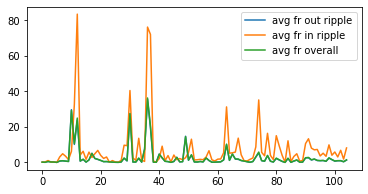

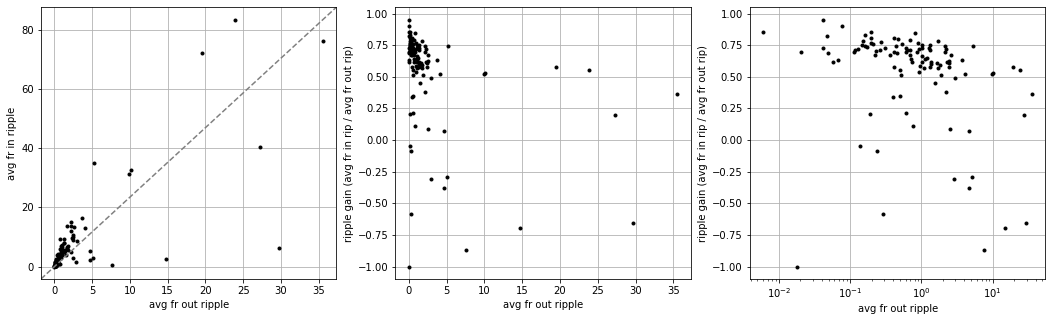

In [72]:
f, ax = plt.subplots(figsize=(6, 3))
ax.plot(avg_fr_not_rip,label='avg fr out ripple')
ax.plot(avg_fr_rip,label='avg fr in ripple')
ax.plot(avg_fr,label='avg fr overall')
ax.legend()

# f, ax = plt.subplots(figsize=(6, 6))
# ax.plot(avg_fr_not_rip,avg_fr_rip,'.k')
# ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',color='grey')
# ax.set_xlabel('avg fr out ripple')
# ax.set_ylabel('avg fr in ripple')
# ax.grid()

f, ax = plt.subplots(1,3,figsize=(18, 5))


ax[0].plot(avg_fr_not_rip,avg_fr_rip,'.k')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes,ls='--',color='grey')
ax[0].set_xlabel('avg fr out ripple')
ax[0].set_ylabel('avg fr in ripple')
ax[0].grid()


ax[1].plot(avg_fr_not_rip,ripple_gain,'.k')
ax[1].set_xlabel('avg fr out ripple')
ax[1].set_ylabel('ripple gain (avg fr in rip / avg fr out rip)')
ax[1].grid()

ax[2].plot(avg_fr_not_rip,ripple_gain,'.k')
ax[2].set_xscale('log')
ax[2].set_xlabel('avg fr out ripple')
ax[2].set_ylabel('ripple gain (avg fr in rip / avg fr out rip)')
ax[2].grid()


# f, ax = plt.subplots(figsize=(6, 6))
# ax.plot(avg_fr,avg_fr_not_rip,'.k')
# ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',color='grey')
# ax.set_xlabel('avg fr')
# ax.set_ylabel('avg fr out ripple')
# ax.grid()

In [84]:
cell_metrics.putativeCellType = [item[0] for item in cell_metrics.putativeCellType]
cell_metrics.putativeCellType



0      Narrow interneuron
1          Pyramidal Cell
2      Narrow interneuron
3      Narrow interneuron
4      Narrow interneuron
              ...        
100        Pyramidal Cell
101        Pyramidal Cell
102        Pyramidal Cell
103        Pyramidal Cell
104        Pyramidal Cell
Name: putativeCellType, Length: 105, dtype: object

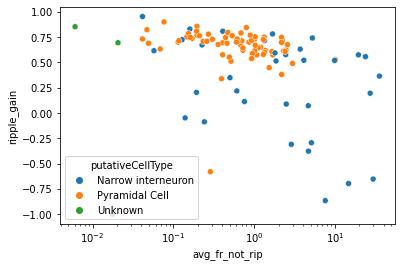

In [93]:
cell_metrics['ripple_gain'] = ripple_gain
cell_metrics['avg_fr_not_rip'] = avg_fr_not_rip

sns.scatterplot(x="avg_fr_not_rip", y="ripple_gain",hue="putativeCellType",data=cell_metrics)
plt.xscale("log")
